Rishi Shah
178003549
Dataset 3

In [969]:
import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex

from sklearn.decomposition import PCA
import glob
import seaborn as sbn
import time 

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import sklearn.metrics
from sklearn.cluster import KMeans 

In [970]:
readDF = pd.read_csv('/Users/RishiShah/Desktop/ML Project/DataSet3/archive (9)/us_election_2020_1st_presidential_debate.csv')
readDF = readDF.append(pd.read_csv('/Users/RishiShah/Desktop/ML Project/DataSet3/archive (9)/us_election_2020_2nd_presidential_debate.csv'))
readDF = readDF.append(pd.read_csv('/Users/RishiShah/Desktop/ML Project/DataSet3/archive (9)/us_election_2020_biden_town_hall.csv'))
readDF = readDF.append(pd.read_csv('/Users/RishiShah/Desktop/ML Project/DataSet3/archive (9)/us_election_2020_trump_town_hall.csv'))
readDF = readDF.drop('minute',axis=1)
debateDF = readDF
debateDF.head()

,speaker,text
0,Chris Wallace,Good evening from the Health Education Campus ...
1,Chris Wallace,This debate is being conducted under health an...
2,Vice President Joe Biden,"How you doing, man?"
3,President Donald J. Trump,How are you doing?
4,Vice President Joe Biden,I’m well.


This step involves loading in the text dataset.

## a. Brief Exploration of Dataset

In [971]:
print("Total number of samples: ",debateDF.shape[0])

Total number of samples:  1928


In [972]:
from collections import Counter
results = Counter()
debateDF['text'].str.lower().str.split().apply(results.update)
print("Number of distinct words: ", len(results))

Number of distinct words:  7047


My dataset covered most of the 2020 election events ranging from the presidential debates to the town halls. There are 1928 samples in total. There are 3522 distinct words in this dataset. Being a text dataset, there has to be a lot of preprocessing done (in the next step), as there are a lot of irrelevant words and features, such as stop words and punctuation. 

## b. Preprocessing of Dataset

In [973]:
import re 
import string

#debateDF['text'] = debateDF['text'].str.lower()
labelsDF = debateDF.drop('speaker',axis=1)
debateDF = debateDF.drop('speaker', axis=1)
debateDF['text'] = debateDF['text'].str.lower()
debateDF['text'] = debateDF['text'].str.replace('\d+', '')
debateDF['text'] = debateDF['text'].str.replace('[^\w\s]','')
debateDF['text'] = debateDF['text'].str.strip()
debateDF.head()

,text
0,good evening from the health education campus ...
1,this debate is being conducted under health an...
2,how you doing man
3,how are you doing
4,im well


This starts the preprocessing phase f the text dataset. I make all the strings lowercase, remove punctuation and numbers, as well as any whitespace. I do this because they are irrelevant in the larger sense and will not be important for the clustering task. We want to focus only on the more relevant, unique words in this dataset and performing these steps along with the subsequent ones will allow us to do this. 

In [974]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
stopWords = stopwords.words('english')
debateDF['text'] = debateDF['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
debateDF.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/RishiShah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text
0,good evening health education campus case west...
1,debate conducted health safety protocols desig...
2,man
3,
4,im well


In this step, I remove all stop words from the dataset. Stopwords are any useless words such as and, I, or, etc. that will not be relevant for the task ahead. We want to give more meaning to the more relevant words in this dataset and this allows us to do so. 

In [975]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer=WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)] 

debateDF['text'] = debateDF['text'].apply(lemmatize_text)
debateDF.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/RishiShah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text
0,"[good, evening, health, education, campus, cas..."
1,"[debate, conducted, health, safety, protocol, ..."
2,[man]
3,[]
4,"[im, well]"


Here, I lemmatize the dataset. The purpose of this is to only keep the base dictionary form of the word and remove all endings such as -ing, -es, etc. This helps give equal meaning to words that otherwise have the same impact on this dataset. 

## c. Feature Extraction

In [976]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
debateDF['text'] = debateDF['text'].apply(lambda x: " ".join(str(l) for l in x))
tfidf = tfidf.fit_transform(debateDF['text'])
tfidf = tfidf.toarray()
print(tfidf)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


I use  Tfidf here to convert the text into a numerical representation. Tfidf, or term frequency - inverse document frequency is based on how important a word is to a document, or in this case, the dataset. Basically, the value increases based on how many times a word appears in a document (term frequency), but that is then offset by how many documents contain that word (inverse document frequency). This latter idf metric is calculated by taking the total amount of samples and dividing it by the number of samples that contain that word, and then taking the log of that number These two values (tf and idf) are multiplied together to get the tf-idf. Putting the data in this format prepares the dataset for the actual machine learning processing later on and is actually better than the typical Bag of Words model because it tries to give an equal value to all words.

In [977]:
pca = PCA(n_components = 2)
pca.fit(tfidf)
pcaTrain = pca.transform(tfidf)
print(pcaTrain)

[[ 0.13383004 -0.02941918]
 [ 0.12499918 -0.03626919]
 [-0.04127298 -0.00093355]
 ...
 [ 0.16913538 -0.05743195]
 [ 0.03107343 -0.01837976]
 [ 0.12422696 -0.02962451]]


Performing PCA here and decreasing the amount of dimensions to 2 will allow us to better visualize the clustering models, since they can be plotted on a graph. 

## d. Processing with ML Methods

In [978]:
from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split 
from scipy.spatial.distance import cdist

xTrain, xTest = train_test_split(pcaTrain, test_size=0.2,train_size=0.8,shuffle=True)

Because I do not have a test dataset, I split it here using train_test_split. 80% of the data is training and 20% of the data is test, and the data is also shuffled for the purposes of reducing bias.

### a. K-Means Clustering

In [979]:
distances = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k, init = 'k-means++')
    km = km.fit(xTrain)
    distances.append(km.inertia_)

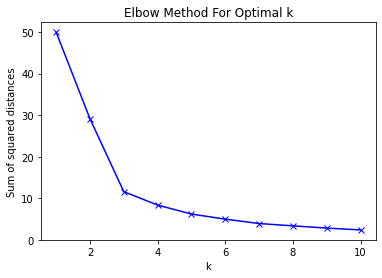

In [980]:
plt.plot(K, distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow method that I used above assists with finding the optimal value for the number of clusters in K Means Clustering. The inertia measurements that are added to the array here represent the sum of squared distances to the closest cluster centroid. I plotted these points a grpah and the point that serves as the corner or "elbow" where the graph starts becoming linear refers to the most optimal cluster number. In this case, this number is 3. 

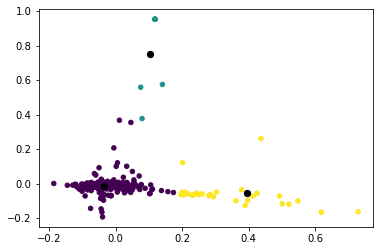

In [981]:
kMeansTime = time.time()
km = KMeans(n_clusters=3, init = 'k-means++').fit(xTrain)
kmResults = km.predict(xTest)
kMeansTime = time.time()-kMeansTime


plt.scatter(xTest[:, 0],xTest[:, 1], c = kmResults, s = 20)
centroids = km.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'black', s = 40);

In [982]:
kMeansSil = sklearn.metrics.silhouette_score(xTest,kmResults)
kMeansDB = sklearn.metrics.davies_bouldin_score(xTest,kmResults)
print("Silhouette Score: ", sklearn.metrics.silhouette_score(xTest,kmResults))
print("Davies-Bouldin Score: ", sklearn.metrics.davies_bouldin_score(xTest,kmResults))

Silhouette Score:  0.7979453894082146
Davies-Bouldin Score:  0.4497167461249704


The higher silhouette score indicates that the clustering was more accurate. We can see from the graph that the clusters are fairly far apart from each other, and the points are fairly compact within their own clusters. However, the clusters are clearly are not evenly distributed. 

K-Means clustering is one of the multiple clustering methods that can be used for machine learning models. It essentially works by finding centroids of clusters and calculating distances from every point to all the centroids. Points switch clusters if they are closer to a different cluster then the one they are already in. This reorganizing of points will go on until none of them shift groups. 

### b. Gaussian Mixture 

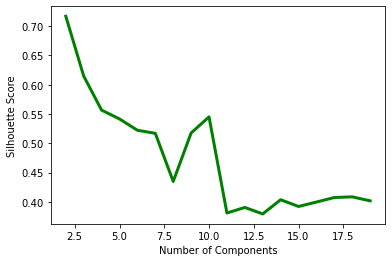

In [983]:
cost = []
for i in range(2, 20): 
  GM = GaussianMixture(n_components = i, covariance_type='full',tol=0.1,max_iter=500).fit(xTrain) 
  GMMPrediction = GM.predict(xTest)
  cost.append(sklearn.metrics.silhouette_score(xTest, GMMPrediction))      
  
plt.plot(range(2, 20), cost, color ='g', linewidth ='3') 
plt.xlabel("Number of Components") 
plt.ylabel("Silhouette Score") 
plt.show()  

This graph represents the Silhouette Score across a variety of values for n_components for the Gaussian Mixture Model. Silhouette score checks how close together the points within a cluster are, as well as how far each cluster is from one another. The maximum value of this graph indicates the number of clusters that should be used.

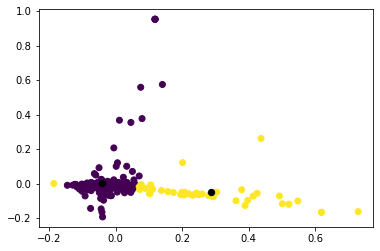

In [1000]:
gmmTime = time.time()
gmm = GaussianMixture(n_components=2, covariance_type='full',tol=0.1,max_iter=500).fit(pcaTrain)
gmmResults = gmm.predict(xTest)
gmmTime = time.time()-gmmTime

plt.scatter(xTest[:, 0], xTest[:, 1], c = gmmResults)
means = gmm.means_
plt.scatter(means[:, 0], means[:, 1], c = 'black', s = 40);

In [985]:
gmmSil = sklearn.metrics.silhouette_score(xTest,gmmResults)
gmmDB  = sklearn.metrics.davies_bouldin_score(xTest,gmmResults)
print("Silhouette Score: ", sklearn.metrics.silhouette_score(xTest,gmmResults))
print("Davies-Bouldin Score: ", sklearn.metrics.davies_bouldin_score(xTest,gmmResults))

Silhouette Score:  0.6373563028894658
Davies-Bouldin Score:  1.417009012055324


The purple cluster in this graph is somewhat compact, however it is not separated from the other yellow cluster well. The yellow cluster also has points that are far away from each other, as well as a couple points that overlap with the other cluster. As a result of this, the silhouette score is lower than in K-Means. This lower score could perhaps indicate that the data is not Gaussian.

GMM, or Gaussian Mixture Model is based on the fact that all points are generated from a Gaussian Distribution. It generalizes the k-means algorithm, by using EM, or expectation estimate the means, covariances, and probabilities for all the clusters. 

### c. K-Medoids Clustering

In [986]:
pip install scikit-learn-extra

Note: you may need to restart the kernel to use updated packages.


In [987]:
from sklearn_extra.cluster import KMedoids

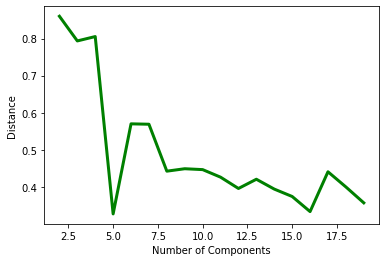

In [988]:
cost = []
for i in range(2, 20): 
  kMed = KMedoids(n_clusters = i, init = 'k-medoids++', max_iter=500).fit(xTrain) 
  labelKMed = kMed.predict(xTest)
  cost.append(sklearn.metrics.silhouette_score(xTest, labelKMed))      
  
plt.plot(range(2, 20), cost, color ='g', linewidth ='3') 
plt.xlabel("Number of Components") 
plt.ylabel("Distance") 
plt.show()  

I use the silhouette score graph again here to find the optimal number of clusters. It is clear here that that number is 3. 

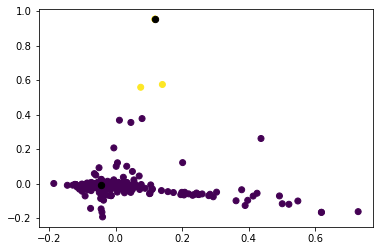

In [1001]:
kMedTime = time.time()
kMed = KMedoids(n_clusters=2,max_iter=500, init = 'k-medoids++').fit(xTrain)
kMedResults = kMed.predict(xTest)
kMedTime = time.time()-kMedTime

plt.scatter(xTest[:, 0], xTest[:, 1], c = kMedResults)
centroids = kMed.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'black', s = 40);

In [996]:
kMedSil = sklearn.metrics.silhouette_score(xTest,kMedResults)
kMedDB  = sklearn.metrics.davies_bouldin_score(xTest,kMedResults)
print("Silhouette Score: ", sklearn.metrics.silhouette_score(xTest,kMedResults))
print("Davies-Bouldin Score: ", sklearn.metrics.davies_bouldin_score(xTest,kMedResults))

Silhouette Score:  0.7571704580822433
Davies-Bouldin Score:  0.5234963695716252


K-Medoids seemed to be a fairly effective clustering algorithm. We can say this because the two clustering groups are pretty compact, as all the points are fairly packed together within their respective clusters. 

K-Medoids works similar to K-means in that it breaks up the data into groups and attempts to minimize the distances between the points and its centroid. However, it is different in that k-medoids chooses actual samples as it's centroids. 

## e. Comparative Analysis 

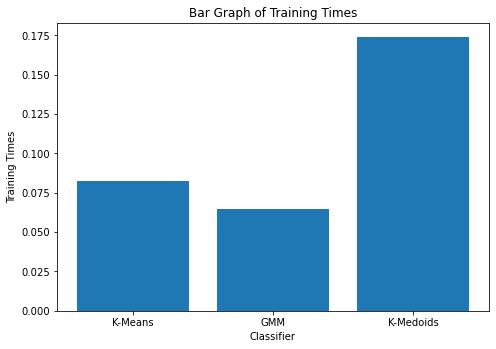

In [997]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['K-Means', 'GMM', 'K-Medoids']
values = [kMeansTime, gmmTime, kMedTime]
ax.bar(labels, values)
ax.set_xlabel('Classifier')
ax.set_ylabel('Training Times')
ax.set_title("Bar Graph of Training Times")
fig.show()



It is clear from this graph that K-medoids takes the most time to run. 

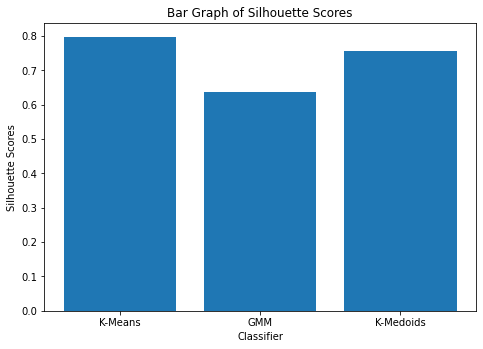

In [998]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['K-Means', 'GMM', 'K-Medoids']
values = [kMeansSil, gmmSil, kMedSil]
ax.bar(labels, values)
ax.set_xlabel('Classifier')
ax.set_ylabel('Silhouette Scores')
ax.set_title("Bar Graph of Silhouette Scores")
fig.show()



A better silhouette score is one that is closer to one, so that means K-Means is the best, K-Medoids is a close second, and GMM is the worst. 

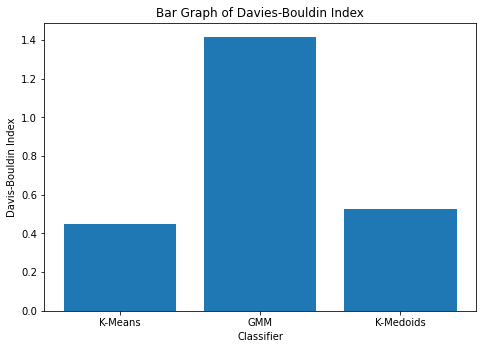

In [999]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['K-Means', 'GMM', 'K-Medoids']
values = [kMeansDB, gmmDB, kMedDB]
ax.bar(labels, values)
ax.set_xlabel('Classifier')
ax.set_ylabel('Davis-Bouldin Index')
ax.set_title("Bar Graph of Davies-Bouldin Index")
fig.show()



The Davies-Bouldin index indicates the average of how close each cluster is to it's most similar cluster. This similaritiy is defined by the ratio of intra-cluster to inter-cluster distances. A lower score indicates better clustering. Thus, the clustering for GMM is more inaccurate then K-Means and K-Medoids.

K-Means would probably be the best for production of this dataset. This is because it has the highest silhouette score and teh lowest Davies-Bouldin score. We can also see from the grpahs above why this is true. 

## f. Discussion of Ethical Issues

The ethical issues with this dataset is that there could perhaps be a spread of misinformation if something that the candidates said was recorded wrong. As everyone knows, misinformation can become very widespread very fast, which ends up causing a lot of unncessary damage to people's reputations. In addition, this type of dataset can set a bad pretext for recording what other people are saying, thus being a violation of privacy. 

## g. Bibliography 

Godfrey, Kate, et al. “Determining The Optimal Number Of Clusters: 3 Must Know Methods.” Datanovia, 21 Oct. 2018, www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/. 

 “Lemmatization of All Pandas Cells.” Stack Overflow, 1 Jan. 1967, stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells. 

Monsters, Data. “Text Preprocessing in Python: Steps, Tools, and Examples.” Medium, Medium, 15 Oct. 2018, medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908. 

“Sklearn.cluster.KMeans¶.” Scikit, scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html. 

“Sklearn.feature_extraction.Text.TfidfVectorizer¶.” Scikit, scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html. 

“Sklearn.mixture.GaussianMixture¶.” Scikit, scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html. 

“sklearn_extra.Cluster.KMedoids¶.” Scikit, scikit-learn-extra.readthedocs.io/en/latest/generated/sklearn_extra.cluster.KMedoids.html. 

Tails, Heads or. “US Election 2020 - Presidential Debates.” Kaggle, 23 Nov. 2020, www.kaggle.com/headsortails/us-election-2020-presidential-debates. 